# [Galaxy Zoo - The Galaxy Challenge](https://www.kaggle.com/c/galaxy-zoo-the-galaxy-challenge)

In this notebook we demonstrate how a convolutional neural network (CNN) can be constructed to analyze images of galaxies to find automated metrics that reproduce the probability distributions derived from human classifications.

Important note: Images provided by Kaggle must be unpacked in a folder called ``./data/images_training_rev1`` (at the root of the project).

We initialize our analysis by simply creating a few variables that will store the path to different directories which we'll be using throughout this notebook:

In [1]:
# Save data directory locations
data_dir = r'../data'
original_data_dir = data_dir + '/images_training_rev1'
training_dir      = data_dir + '/training'
validation_dir    = data_dir + '/validation'
test_dir          = data_dir + '/test'

Next, let's load the path of all the images provided in the training dataset:

In [2]:
import glob

def load_img_paths():
    '''
    Retrieve the full path of all images in the original training dataset
    '''
    return glob.glob(original_data_dir + '/*.jpg')

# Load image file names
img_paths = load_img_paths()
img_paths[0:5]

['../data/images_training_rev1\\100008.jpg',
 '../data/images_training_rev1\\100023.jpg',
 '../data/images_training_rev1\\100053.jpg',
 '../data/images_training_rev1\\100078.jpg',
 '../data/images_training_rev1\\100090.jpg']

We can now render an image as follows:

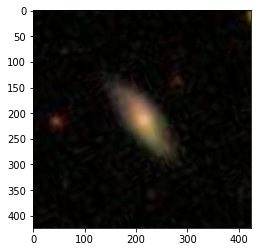

In [41]:
import matplotlib.pylab as plt
%matplotlib inline

sample_img = plt.imread(img_paths[1])
plt.imshow(sample_img)
plt.show()

The images given in the dataset are of size 424x424, but by visual inspection it can be noted that the object of interest is in the center of the image. This means we can crop the image (which will help reduce dimentionality), and still have little effect on the performance of our model. We have chosen to crop the images to half their size (212x212):

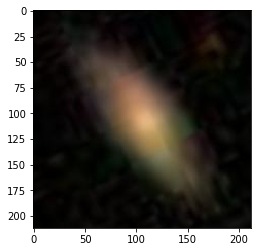

In [42]:
# Example of how to crop an image
sample_img = sample_img.T[:,106:106*3,106:106*3]
plt.imshow(sample_img.T)
plt.show()

Additionally, we can use down-sampling to further reduce dimensionality:

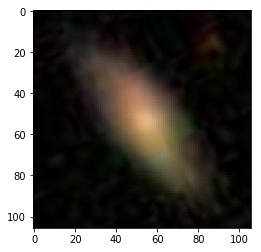

In [45]:
from skimage.transform import resize

# Example of how to down-sample an image
sample_img = resize(sample_img, (3, 106, 106), mode='reflect')
plt.imshow(sample_img.T)

Run this cell many times to get an idea of how the data augmenter works.

rot 0


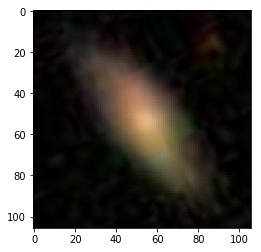

In [83]:
import numpy as np

# proper flip https://github.com/keras-team/keras/blob/master/keras/preprocessing/image.py#L323-L327
def flip_axis(x, axis):
    x = np.asarray(x).swapaxes(axis, 0)
    x = x[::-1, ...]
    x = x.swapaxes(0, axis)
    return x

def random_rotation(x):
    count = np.random.randint(0,4)
    print('rot %d' % (count * 90))
    x1 = np.rot90(x, count)
    return x

def rand_augment(img):
    if np.random.randint(0,2):
        img = flip_axis(img, 1)
        print('flip x')
    if np.random.randint(0,2):
        img = flip_axis(img, 2)
        print('flip y')
    img = random_rotation(img)
    return img
aug_img = rand_augment(sample_img)
plt.imshow(aug_img.T)

The traning dataset provided by Kaggle contains a total of 61578 images. To create a process which yields a faster feedback loop of how well our model is working, we'll create smaller traning, validation, and test sets. The code below simply randomly selects a number of images specified in the ``train_size``, ``validation_size``, and ``test_size`` variables to become part of a particular set. Notice each image can only be part of a single set.

In [11]:
import math
import random
import os
import shutil

def create_temp_datasets(img_paths, train_size = 4, validation_size = 2, test_size = 4):
    '''
    Randomly select images to be in the training, validation, and test datasets
    '''
    assert(len(img_paths) > 0)
    assert(train_size > 0)
    assert(validation_size > 0)
    assert(test_size > 0)
    assert(len(img_paths) >= (train_size + validation_size + test_size))

    # Randomly select images that will be in each set
    random.shuffle(img_paths)
    train_img_paths = img_paths[0:train_size]
    validation_img_paths = img_paths[train_size: (train_size + validation_size)]
    test_img_paths = img_paths[(train_size + validation_size): (train_size + validation_size + test_size)]
    
    # Create training, validation, and test directories 
    remove_temp_datasets()
    dirs = [training_dir, validation_dir, test_dir]
    for x in dirs:
        os.makedirs(x)
        
    # Place training, validation, and test images in their respective directories
    for x in train_img_paths:
        shutil.copyfile(x, x.replace(original_data_dir, training_dir))
    for x in validation_img_paths:
        shutil.copyfile(x, x.replace(original_data_dir, validation_dir))
    for x in test_img_paths:
        shutil.copyfile(x, x.replace(original_data_dir, test_dir))
        
def remove_temp_datasets():
    '''
    Remove directories that were temporary created to save the training, validation, and test datasets
    '''
    dirs = [training_dir, validation_dir, test_dir]
    for x in dirs:
        if os.path.exists(x):
            shutil.rmtree(x)

So let's execute the code and create the new training, validation, and tests sets:

In [13]:
# Declare the size of each of the datasets we'll be dealing with
data_size = len(img_paths)
train_size      = int(data_size * 0.4)
validation_size = int(data_size * 0.4)
test_size       = int(data_size * 0.2)

print('creating splits == tr:%d vl:%d ts:%d' % (train_size, validation_size, test_size))

# Create datasets directories
if len(img_paths) > 0:
    create_temp_datasets(img_paths, train_size, validation_size, test_size)
else:
    msg = """
        No images were found in the '%s' directory. Please make sure all data provided by Kaggle is unpacked in the './data/' folder (at the root of the project) with no modification to their names.
    """ % original_data_dir
    print(msg)

creating splits == tr:12178 vl:12178 ts:6089
